In [1]:
import tensorflow as tf
import FinanceDataReader as fdr
import csv
import numpy as np
from tensorflow.contrib import rnn
import matplotlib
import os
import matplotlib.pyplot as plt
fdr.__version__

'0.7.1'

In [2]:
def write_file(data_list, file_name):
    with open(file_name,'w', newline='') as f:
        data_list = np.array(data_list)
        writer = csv.writer(f)
        writer.writerows(data_list)
    return

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def extract_x_and_y(data, sequence_length, plus_days_to_predict=0):
    data_x = []
    data_y = []
    for i in range(0, len(data) - sequence_length):
        x = data[i:i + sequence_length]
        if i + sequence_length + plus_days_to_predict < len(data):
            y = data[i + sequence_length + plus_days_to_predict, [3]]
        else:
            y = 0
        data_x.append(x)
        data_y.append(y)
    return np.array(data_x), np.array(data_y)

# Make a lstm cell with hidden_size (each unit output vector size)
def lstm_cell(hidden_size):
    cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    return cell

def getDailyStockPriceData(code, startDate, endDate, sequence_length, plus_days_to_predict):
    data = np.array(fdr.DataReader(code, startDate, endDate))
    data = MinMaxScaler(data[:, 1:-1]) #시작가격, 최고가, 최적가, 종가, 거래량
    return extract_x_and_y(data, sequence_length, plus_days_to_predict)

In [3]:
# country code: ex) 000150: Doosan(KR), Yihua Healthcare(CN)
code = '005930'
data = np.array(fdr.DataReader(code, '1992-01-01', '2017-12-31'))
data = MinMaxScaler(data[:, 1:-1]) #시작가격, 최고가, 최적가, 종가, 거래량
print("shape:", data.shape, "\n", "data[0]: ", data[0])

test_data = np.array(fdr.DataReader('000150', '2018-01-01', '2018-12-29'))
test_data = MinMaxScaler(test_data[:, 1:-1]) #시작가격, 최고가, 최적가, 종가, 거래량

shape: (5756, 5) 
 data[0]:  [0.01482667041874382 0.014492498724845678 0.01499928744475025
 0.014842825084348164 0.00613960227656443]


In [4]:
data_dim = 5
hidden_dim = 10
num_classes = 1
sequence_length = 5

data_x, data_y = extract_x_and_y(data, sequence_length)
test_data_x, test_data_y = extract_x_and_y(test_data, sequence_length)

batch_size = None
learning_rate = 0.01

In [5]:
#이전 예제에서는 x y 를 one hot encoding으로 변환해서 사용했는데  
# 지금 예제에서는 어떻게 사용할 것인가.
# X = [0.2322834645664719 0.23285198555914646 0.2284569138271975
# 0.2538759689917561 0.052436875076320326]   -> [1] 다음날 가격 오름  [0] 다음날 가격 떨어짐 y를 [?, 1] shape으로 변환해서 만들어야 할듯

In [6]:
X = tf.placeholder(tf.float32, [batch_size, sequence_length, data_dim])
Y = tf.placeholder(tf.float32, [batch_size, num_classes])
print("shape of X: ", X)
print("shape of Y: ", Y)

shape of X:  Tensor("Placeholder:0", shape=(?, 5, 5), dtype=float32)
shape of Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [7]:
cell = rnn.MultiRNNCell([lstm_cell(hidden_dim) for _ in range(2)], state_is_tuple=True)
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

In [8]:
# outputs: unfolding size x hidden size, state = hidden size
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
print(outputs)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_dim])
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [-1, sequence_length, num_classes])

# We use the last cell's output
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], num_classes, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

Tensor("rnn/transpose_1:0", shape=(?, 5, 10), dtype=float32)


In [9]:
# RMSE
expected_results = tf.placeholder(tf.float32, [batch_size, 1])
predictions = tf.placeholder(tf.float32, [batch_size, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(expected_results - predictions)))

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(20000):
    _, step_loss = sess.run([train_op, loss], feed_dict={X: data_x, Y: data_y})
    if i % 1000 == 0:
        print("[step: {}] loss: {}".format(i, step_loss))

[step: 0] loss: 603.3369140625
[step: 1000] loss: 0.2916908264160156
[step: 2000] loss: 0.19596071541309357
[step: 3000] loss: 0.17907966673374176
[step: 4000] loss: 0.17416492104530334
[step: 5000] loss: 0.17105744779109955
[step: 6000] loss: 0.16893704235553741
[step: 7000] loss: 0.20250889658927917
[step: 8000] loss: 0.16707395017147064
[step: 9000] loss: 0.16840189695358276
[step: 10000] loss: 0.1659558117389679
[step: 11000] loss: 0.19891539216041565
[step: 12000] loss: 0.1648968905210495
[step: 13000] loss: 0.16430634260177612
[step: 14000] loss: 0.16386324167251587
[step: 15000] loss: 0.16327442228794098
[step: 16000] loss: 0.16414345800876617
[step: 17000] loss: 0.16181586682796478
[step: 18000] loss: 0.17621468007564545
[step: 19000] loss: 0.16126003861427307


RMSE: 0.00530714076012373


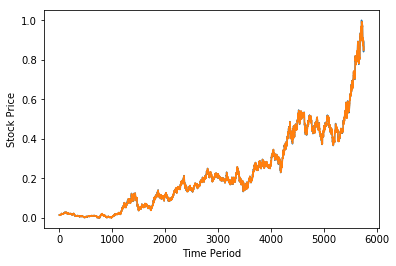

In [11]:
#Compare tarining x and y
predict = sess.run(Y_pred, feed_dict={X: data_x})
rmse_val = sess.run(rmse, feed_dict={expected_results: data_y, predictions: predict})
print("RMSE: {}".format(rmse_val))

# Plot predictions
plt.plot(data_y)
plt.plot(predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

RMSE: 0.05660180747509003


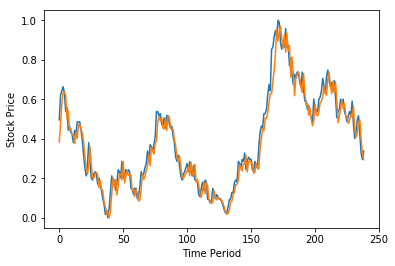

expeced:


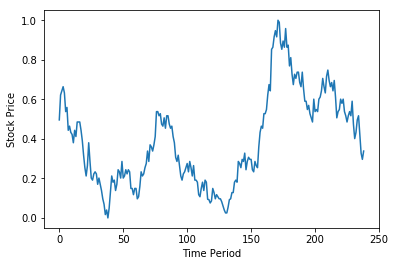

predicted:


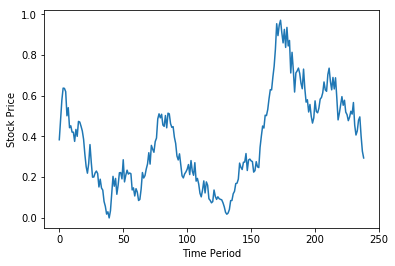

In [12]:
# Test step
test_predict = sess.run(Y_pred, feed_dict={X: test_data_x})
rmse_val = sess.run(rmse, feed_dict={expected_results: test_data_y, predictions: test_predict})
print("RMSE: {}".format(rmse_val))

# Plot predictions
plt.plot(test_data_y)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# test Y
print("expeced:")
plt.plot(test_data_y)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# predict Y
print("predicted:")
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

RMSE: 0.20204630494117737


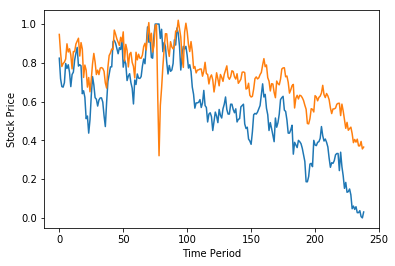

expected: 


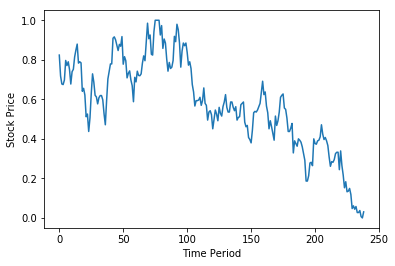

predicted: 


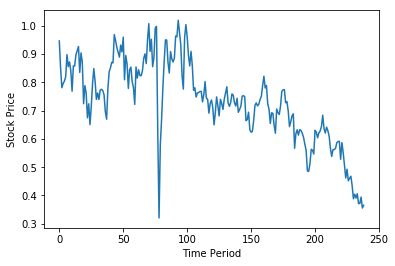

In [13]:
test_data_2 = np.array(fdr.DataReader('005930', '2018-01-01', '2018-12-29'))
test_data_2 = MinMaxScaler(test_data_2[:, 1:-1]) #시작가격, 최고가, 최적가, 종가, 거래량
test_data_x_2, test_data_y_2 = extract_x_and_y(test_data_2, sequence_length)

# Test step
test_predict_2 = sess.run(Y_pred, feed_dict={X: test_data_x_2})
rmse_val = sess.run(rmse, feed_dict={expected_results: test_data_y_2, predictions: test_predict_2})
print("RMSE: {}".format(rmse_val))

# Plot predictions
plt.plot(test_data_y_2)
plt.plot(test_predict_2)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# Plot predictions
print("expected: ")
plt.plot(test_data_y_2)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# Plot predictions
print("predicted: ")
plt.plot(test_predict_2)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

RMSE: 0.0
both: 


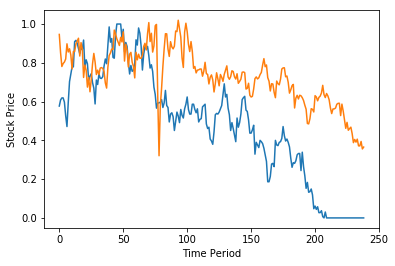

expected: 


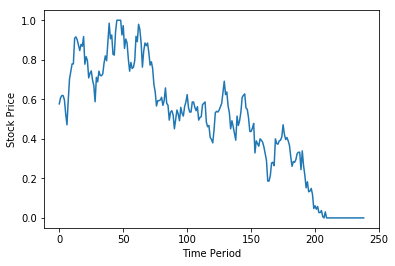

predicted: 


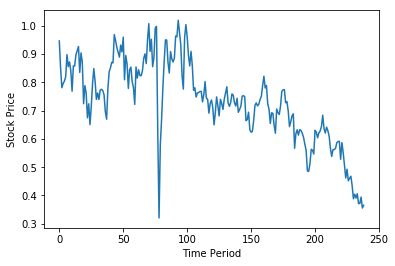

In [18]:
test_data_x_3, test_data_y_3 = getDailyStockPriceData('005930', '2018-01-01', '2018-12-29', 5, 30)
# Test step
test_predict_3 = sess.run(Y_pred, feed_dict={X: test_data_x_3})
rmse_val = sess.run(rmse, feed_dict={expected_results: test_predict_3, predictions: test_predict_3})
print("RMSE: {}".format(rmse_val))

print("both: ")
plt.plot(test_data_y_3)
plt.plot(test_predict_3)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# Plot predictions
print("expected: ")
plt.plot(test_data_y_3)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# Plot predictions
print("predicted: ")
plt.plot(test_predict_3)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()
